# Implementing CIFAR10 using deep learning

In [26]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import datasets,models, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True
import os
from keras.datasets import cifar10

# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

horse  dog  dog frog bird  dog  dog


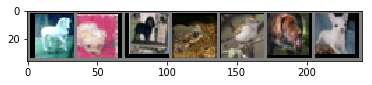

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# # show images
imshow(torchvision.utils.make_grid(images[0:7],nrow = 8))
# print labels
print(''.join('%5s' % classes[labels[j]] for j in range(7)))

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. After taking suggestions from comments on Piazza, I tried implementing VGG.
* After Implementing different VGG Networks, VGG13 gave the best results. 
* I modified the original network to increase accuracy from 80 to 83 percent. This was due to changing the activation function and using dropouts.


In [24]:
# Code Modified from  https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
config = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128,'D', 128, 'M', 256,'D', 256, 256, 256, 'M', 512,'D', 512, 512, 512, 'M', 512,'D', 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.conv = self._make_layers(config[vgg_name])
        self.linear = self._make_layers_linear()

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def vis(self, x):
        out = self.conv(x)
        return out
    
    def swish(self,x):
        return x * torch.sigmoid(x) # Tried using this, but as the error did not converge, not used later on.

    def _make_layers(self, config):
        layers = []
        in_channels = 3
        for x in config:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
            elif x == 'D':
                layers+= [nn.Dropout(0.5)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # Padding is adjusted 
                                                                               # To presever spatial dimension. 
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]#inplace=True, PReLU()
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def _make_layers_linear(self):
        layers = []
#         layers +=[nn.Linear(512, 256)]
#         layers+= [nn.Dropout(0.5)]
        layers += [nn.Linear(512, 10)]
#         layers += [nn.LogSoftmax()]
#         layers += [nn.Linear(64, 5)]
        return nn.Sequential(*layers) # Try softmax here

# net = VGG('VGG1')
# net = shufflenetv2
net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
torch.backends.cudnn.benchmark = True


AttributeError: module 'shufflenetv2' has no attribute 'to'

In [5]:
net

DataParallel(
  (module): VGG(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Dropout(p=0.5)
      (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace)
      (14): MaxPool2d(kernel_size=2, stride=2, paddin

In [6]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]           1,792
       BatchNorm2d-3           [-1, 64, 32, 32]             128
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        MaxPool2d-12           [-1, 64, 16, 16]               0
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

## Explanations for Network Architecture

* The Loss function used is cross entropy class as there are multiple classes (5)
* The model architecture adopted was that of VGG 13. This is because: 
     * the accuracy was in the range of 64 – 71 percent with a 5 layer network (input – conv1 – conv2- linear - crossentropyloss) .
    * Convolutions were used as the input is 2D images. 
    * Even after adding dropouts of 0.2 and 0.5 in between the convolution layers the accuracy did not improve.
     * Conclusion: as the networks needs to learn RGB images and distinguish 5 labels, it will need more parameters to shatter the input space.  Also the images are very blurry, this adds on to the number of parameters needed as differentiating becomes more difficult.
* VGG 11 also did not give accuracies above 75 percent. As I was able to get descent accuracy with Vgg 13, I did not experiment with this network.
* The Optimizer with Vgg13 is taken as Adam, as it got me better accuracies than SGD. This may be because Adam is able to avoid local minima and does not get stuck. 
* Learning rate of 0.002 gets me a good error convergence graph. Increase the learning rate to 0.01 also gives similar results much faster, but then convergence graph is like a step function and therefore avoided.
* Some other experimentation with dropouts and different activations like (swish, relu and Prelu) can be seen in the screen shot of the excel file I made in the Ipython Notebook.
* Each filter or weights of the convolution layers is visualized, in the image shown below.
    * The image is a representation of weights of the first kernel in each layer (only a depth size of 3 is visualized for each convolution layer)
    * we can see that the weights initialized is different for each layer. ( as they have different colors).


## Visualizaing Weights

In [7]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0:3])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Showing the weights of the first kernel in each convolution layer
(64, 3, 3, 3)


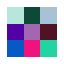

(64, 64, 3, 3)


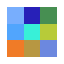

(128, 64, 3, 3)


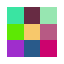

(128, 128, 3, 3)


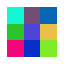

(256, 128, 3, 3)


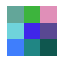

(256, 256, 3, 3)


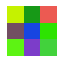

(512, 256, 3, 3)


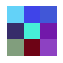

(512, 512, 3, 3)


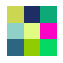

(512, 512, 3, 3)


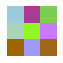

(512, 512, 3, 3)


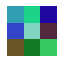

In [8]:
visnet = VGG('VGG13')
visnet = visnet.to('cpu').double()
print("Showing the weights of the first kernel in each convolution layer")
for m in visnet.modules():
    if isinstance(m, nn.Conv2d):   
        a = m.weight.data.numpy()
#         print(tensor.max())
        c = (a - np.min(a))/np.ptp(a).astype(float)
        print(c.shape)
        plot_kernels(c)
#         break


##  Define a Loss function and optimizer
* Cross Entropy Loss is used as there are multiiple classes (5). 
* Different Permuation of the learning rate and optimizers were tried. The table I created for getting intition for accuracy and error can be found below or attached with homework sumission.
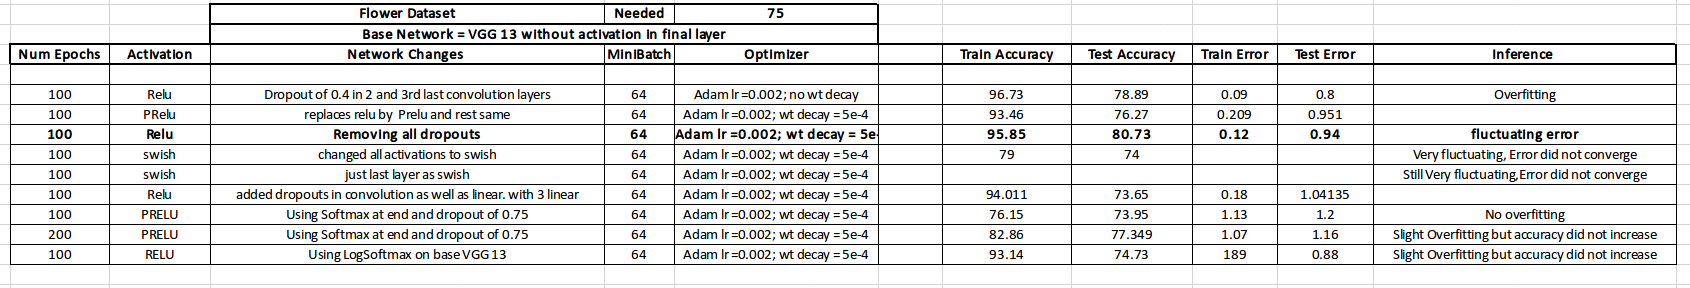
* After all the experimentation, the original vgg 13 network worked the best. Adding dropouts did not help, I guess this is due to not adding them at the right position. I also tried increasing the fully connected layers but it did not help.
* The most significant discrepancy was found that, when not using softmax layer or log softmax layer, the testing accuracy actually came out to be more. I dont know why this happened!!! 

In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
# optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]
best_acc= 0  # best test accuracy


In [10]:
device

'cuda'

In [11]:
# # For Debugging
# for batch_idx, (data, target) in enumerate(train_loader):
#     data, target = data.to(device), target.to(device)
#     output = net(data)
# # #         print(target.dtype,output.dtype)
#     loss = criterion(output, target)
#     loss.backward()
#     optimizer.step()
#     break
# # target

## Training and Testing Functions

In [12]:
def train(model, train_loader, optimizer, epoch,device):
#     print(criterion)
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    global best_acc
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Save checkpoint.
    acc = 100.*correct/len(test_loader.dataset)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'val_loss': val_loss,
            'test_accu': test_accu, 
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
    best_acc = acc

## Resume trained network if needed 

In [13]:
start_epoch = 0 # start from epoch 0 or last checkpoint epoch

# print('==> Resuming from checkpoint..')
# assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
# checkpoint = torch.load('./checkpoint/ckpt.t7')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# start_epoch = checkpoint['epoch']

In [14]:
# a= net.state_dict(checkpoint['val_loss'])

# Training the Model

In [15]:
for epoch in range(start_epoch, 100):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.297843
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.272731
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.212531
Train Epoch: 0 [7680/50000 (15%)]	Loss: 2.048845
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.060076
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.053138
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.916442
Train Epoch: 0 [17920/50000 (36%)]	Loss: 1.885529
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.857259
Train Epoch: 0 [23040/50000 (46%)]	Loss: 1.947439
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.804414
Train Epoch: 0 [28160/50000 (56%)]	Loss: 1.748366
Train Epoch: 0 [30720/50000 (61%)]	Loss: 1.873536
Train Epoch: 0 [33280/50000 (66%)]	Loss: 1.797990
Train Epoch: 0 [35840/50000 (72%)]	Loss: 1.751790
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.757186
Train Epoch: 0 [40960/50000 (82%)]	Loss: 1.789122
Train Epoch: 0 [43520/50000 (87%)]	Loss: 1.627507
Train Epoch: 0 [46080/50000 (92%)]	Loss: 1.725976
Train Epoch: 0 [48640/50000 (97%)]	Loss: 1.571741

Test set

Train Epoch: 7 [40960/50000 (82%)]	Loss: 0.893200
Train Epoch: 7 [43520/50000 (87%)]	Loss: 0.963211
Train Epoch: 7 [46080/50000 (92%)]	Loss: 0.991825
Train Epoch: 7 [48640/50000 (97%)]	Loss: 0.974523

Test set: Average loss: 0.9759, Accuracy: 6539/10000 (65%)

Saving..
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.891565
Train Epoch: 8 [2560/50000 (5%)]	Loss: 0.865984
Train Epoch: 8 [5120/50000 (10%)]	Loss: 0.874701
Train Epoch: 8 [7680/50000 (15%)]	Loss: 0.869963
Train Epoch: 8 [10240/50000 (20%)]	Loss: 0.784765
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.004600
Train Epoch: 8 [15360/50000 (31%)]	Loss: 0.970254
Train Epoch: 8 [17920/50000 (36%)]	Loss: 0.885363
Train Epoch: 8 [20480/50000 (41%)]	Loss: 0.899578
Train Epoch: 8 [23040/50000 (46%)]	Loss: 0.861922
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.849903
Train Epoch: 8 [28160/50000 (56%)]	Loss: 0.840460
Train Epoch: 8 [30720/50000 (61%)]	Loss: 0.899415
Train Epoch: 8 [33280/50000 (66%)]	Loss: 0.856373
Train Epoch: 8 [35840/50000 (72%)]	Loss

Train Epoch: 15 [20480/50000 (41%)]	Loss: 0.677842
Train Epoch: 15 [23040/50000 (46%)]	Loss: 0.571749
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.639609
Train Epoch: 15 [28160/50000 (56%)]	Loss: 0.637259
Train Epoch: 15 [30720/50000 (61%)]	Loss: 0.868471
Train Epoch: 15 [33280/50000 (66%)]	Loss: 0.673458
Train Epoch: 15 [35840/50000 (72%)]	Loss: 0.808170
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.648325
Train Epoch: 15 [40960/50000 (82%)]	Loss: 0.593489
Train Epoch: 15 [43520/50000 (87%)]	Loss: 0.786669
Train Epoch: 15 [46080/50000 (92%)]	Loss: 0.749554
Train Epoch: 15 [48640/50000 (97%)]	Loss: 0.826461

Test set: Average loss: 0.7376, Accuracy: 7463/10000 (75%)

Saving..
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.853126
Train Epoch: 16 [2560/50000 (5%)]	Loss: 0.553818
Train Epoch: 16 [5120/50000 (10%)]	Loss: 0.702785
Train Epoch: 16 [7680/50000 (15%)]	Loss: 0.613765
Train Epoch: 16 [10240/50000 (20%)]	Loss: 0.602930
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.660788
Train Epoch: 16 [1536

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.332320
Train Epoch: 23 [2560/50000 (5%)]	Loss: 0.476932
Train Epoch: 23 [5120/50000 (10%)]	Loss: 0.582367
Train Epoch: 23 [7680/50000 (15%)]	Loss: 0.566594
Train Epoch: 23 [10240/50000 (20%)]	Loss: 0.422793
Train Epoch: 23 [12800/50000 (26%)]	Loss: 0.489643
Train Epoch: 23 [15360/50000 (31%)]	Loss: 0.439405
Train Epoch: 23 [17920/50000 (36%)]	Loss: 0.428193
Train Epoch: 23 [20480/50000 (41%)]	Loss: 0.637596
Train Epoch: 23 [23040/50000 (46%)]	Loss: 0.541950
Train Epoch: 23 [25600/50000 (51%)]	Loss: 0.594601
Train Epoch: 23 [28160/50000 (56%)]	Loss: 0.580072
Train Epoch: 23 [30720/50000 (61%)]	Loss: 0.537071
Train Epoch: 23 [33280/50000 (66%)]	Loss: 0.543293
Train Epoch: 23 [35840/50000 (72%)]	Loss: 0.614213
Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.478935
Train Epoch: 23 [40960/50000 (82%)]	Loss: 0.554867
Train Epoch: 23 [43520/50000 (87%)]	Loss: 0.480649
Train Epoch: 23 [46080/50000 (92%)]	Loss: 0.686996
Train Epoch: 23 [48640/50000 (97%)]	Loss

Train Epoch: 30 [33280/50000 (66%)]	Loss: 0.495139
Train Epoch: 30 [35840/50000 (72%)]	Loss: 0.523839
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.405633
Train Epoch: 30 [40960/50000 (82%)]	Loss: 0.373719
Train Epoch: 30 [43520/50000 (87%)]	Loss: 0.474576
Train Epoch: 30 [46080/50000 (92%)]	Loss: 0.403350
Train Epoch: 30 [48640/50000 (97%)]	Loss: 0.625402

Test set: Average loss: 0.5617, Accuracy: 8091/10000 (81%)

Saving..
Train Epoch: 31 [0/50000 (0%)]	Loss: 0.491045
Train Epoch: 31 [2560/50000 (5%)]	Loss: 0.407347
Train Epoch: 31 [5120/50000 (10%)]	Loss: 0.360668
Train Epoch: 31 [7680/50000 (15%)]	Loss: 0.428160
Train Epoch: 31 [10240/50000 (20%)]	Loss: 0.301752
Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.483290
Train Epoch: 31 [15360/50000 (31%)]	Loss: 0.579126
Train Epoch: 31 [17920/50000 (36%)]	Loss: 0.362753
Train Epoch: 31 [20480/50000 (41%)]	Loss: 0.450310
Train Epoch: 31 [23040/50000 (46%)]	Loss: 0.335334
Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.347393
Train Epoch: 31 [2816

Train Epoch: 38 [12800/50000 (26%)]	Loss: 0.403329
Train Epoch: 38 [15360/50000 (31%)]	Loss: 0.610819
Train Epoch: 38 [17920/50000 (36%)]	Loss: 0.234249
Train Epoch: 38 [20480/50000 (41%)]	Loss: 0.356844
Train Epoch: 38 [23040/50000 (46%)]	Loss: 0.392210
Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.424718
Train Epoch: 38 [28160/50000 (56%)]	Loss: 0.413867
Train Epoch: 38 [30720/50000 (61%)]	Loss: 0.407634
Train Epoch: 38 [33280/50000 (66%)]	Loss: 0.453483
Train Epoch: 38 [35840/50000 (72%)]	Loss: 0.491885
Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.455956
Train Epoch: 38 [40960/50000 (82%)]	Loss: 0.437034
Train Epoch: 38 [43520/50000 (87%)]	Loss: 0.365624
Train Epoch: 38 [46080/50000 (92%)]	Loss: 0.288088
Train Epoch: 38 [48640/50000 (97%)]	Loss: 0.462204

Test set: Average loss: 0.5542, Accuracy: 8145/10000 (81%)

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.267306
Train Epoch: 39 [2560/50000 (5%)]	Loss: 0.336973
Train Epoch: 39 [5120/50000 (10%)]	Loss: 0.425106
Train Epoch: 39 [7680/50000 (

Train Epoch: 45 [46080/50000 (92%)]	Loss: 0.467377
Train Epoch: 45 [48640/50000 (97%)]	Loss: 0.432966

Test set: Average loss: 0.4889, Accuracy: 8361/10000 (84%)

Saving..
Train Epoch: 46 [0/50000 (0%)]	Loss: 0.406667
Train Epoch: 46 [2560/50000 (5%)]	Loss: 0.365139
Train Epoch: 46 [5120/50000 (10%)]	Loss: 0.257340
Train Epoch: 46 [7680/50000 (15%)]	Loss: 0.331108
Train Epoch: 46 [10240/50000 (20%)]	Loss: 0.426988
Train Epoch: 46 [12800/50000 (26%)]	Loss: 0.416939
Train Epoch: 46 [15360/50000 (31%)]	Loss: 0.338809
Train Epoch: 46 [17920/50000 (36%)]	Loss: 0.321347
Train Epoch: 46 [20480/50000 (41%)]	Loss: 0.321741
Train Epoch: 46 [23040/50000 (46%)]	Loss: 0.417563
Train Epoch: 46 [25600/50000 (51%)]	Loss: 0.428904
Train Epoch: 46 [28160/50000 (56%)]	Loss: 0.381940
Train Epoch: 46 [30720/50000 (61%)]	Loss: 0.356191
Train Epoch: 46 [33280/50000 (66%)]	Loss: 0.362230
Train Epoch: 46 [35840/50000 (72%)]	Loss: 0.337948
Train Epoch: 46 [38400/50000 (77%)]	Loss: 0.400259
Train Epoch: 46 [4096

Train Epoch: 53 [25600/50000 (51%)]	Loss: 0.463708
Train Epoch: 53 [28160/50000 (56%)]	Loss: 0.407574
Train Epoch: 53 [30720/50000 (61%)]	Loss: 0.381962
Train Epoch: 53 [33280/50000 (66%)]	Loss: 0.435892
Train Epoch: 53 [35840/50000 (72%)]	Loss: 0.409820
Train Epoch: 53 [38400/50000 (77%)]	Loss: 0.291813
Train Epoch: 53 [40960/50000 (82%)]	Loss: 0.325477
Train Epoch: 53 [43520/50000 (87%)]	Loss: 0.353176
Train Epoch: 53 [46080/50000 (92%)]	Loss: 0.355029
Train Epoch: 53 [48640/50000 (97%)]	Loss: 0.246870

Test set: Average loss: 0.4989, Accuracy: 8390/10000 (84%)

Train Epoch: 54 [0/50000 (0%)]	Loss: 0.338370
Train Epoch: 54 [2560/50000 (5%)]	Loss: 0.267125
Train Epoch: 54 [5120/50000 (10%)]	Loss: 0.322554
Train Epoch: 54 [7680/50000 (15%)]	Loss: 0.351459
Train Epoch: 54 [10240/50000 (20%)]	Loss: 0.370508
Train Epoch: 54 [12800/50000 (26%)]	Loss: 0.443088
Train Epoch: 54 [15360/50000 (31%)]	Loss: 0.324289
Train Epoch: 54 [17920/50000 (36%)]	Loss: 0.337256
Train Epoch: 54 [20480/50000 (

Train Epoch: 61 [5120/50000 (10%)]	Loss: 0.322833
Train Epoch: 61 [7680/50000 (15%)]	Loss: 0.358529
Train Epoch: 61 [10240/50000 (20%)]	Loss: 0.340891
Train Epoch: 61 [12800/50000 (26%)]	Loss: 0.325624
Train Epoch: 61 [15360/50000 (31%)]	Loss: 0.352768
Train Epoch: 61 [17920/50000 (36%)]	Loss: 0.335646
Train Epoch: 61 [20480/50000 (41%)]	Loss: 0.262750
Train Epoch: 61 [23040/50000 (46%)]	Loss: 0.344608
Train Epoch: 61 [25600/50000 (51%)]	Loss: 0.271501
Train Epoch: 61 [28160/50000 (56%)]	Loss: 0.455548
Train Epoch: 61 [30720/50000 (61%)]	Loss: 0.308969
Train Epoch: 61 [33280/50000 (66%)]	Loss: 0.360131
Train Epoch: 61 [35840/50000 (72%)]	Loss: 0.270829
Train Epoch: 61 [38400/50000 (77%)]	Loss: 0.294646
Train Epoch: 61 [40960/50000 (82%)]	Loss: 0.280707
Train Epoch: 61 [43520/50000 (87%)]	Loss: 0.315597
Train Epoch: 61 [46080/50000 (92%)]	Loss: 0.177052
Train Epoch: 61 [48640/50000 (97%)]	Loss: 0.414554

Test set: Average loss: 0.4553, Accuracy: 8484/10000 (85%)

Saving..
Train Epoch: 6

Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.135462
Train Epoch: 68 [40960/50000 (82%)]	Loss: 0.207793
Train Epoch: 68 [43520/50000 (87%)]	Loss: 0.245573
Train Epoch: 68 [46080/50000 (92%)]	Loss: 0.214902
Train Epoch: 68 [48640/50000 (97%)]	Loss: 0.202795

Test set: Average loss: 0.4783, Accuracy: 8444/10000 (84%)

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.259768
Train Epoch: 69 [2560/50000 (5%)]	Loss: 0.301807
Train Epoch: 69 [5120/50000 (10%)]	Loss: 0.406066
Train Epoch: 69 [7680/50000 (15%)]	Loss: 0.381096
Train Epoch: 69 [10240/50000 (20%)]	Loss: 0.264933
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.285998
Train Epoch: 69 [15360/50000 (31%)]	Loss: 0.270398
Train Epoch: 69 [17920/50000 (36%)]	Loss: 0.192381
Train Epoch: 69 [20480/50000 (41%)]	Loss: 0.221596
Train Epoch: 69 [23040/50000 (46%)]	Loss: 0.310552
Train Epoch: 69 [25600/50000 (51%)]	Loss: 0.234596
Train Epoch: 69 [28160/50000 (56%)]	Loss: 0.450888
Train Epoch: 69 [30720/50000 (61%)]	Loss: 0.327989
Train Epoch: 69 [33280/50000 (

Train Epoch: 76 [17920/50000 (36%)]	Loss: 0.331975
Train Epoch: 76 [20480/50000 (41%)]	Loss: 0.277411
Train Epoch: 76 [23040/50000 (46%)]	Loss: 0.216222
Train Epoch: 76 [25600/50000 (51%)]	Loss: 0.294564
Train Epoch: 76 [28160/50000 (56%)]	Loss: 0.161627
Train Epoch: 76 [30720/50000 (61%)]	Loss: 0.314900
Train Epoch: 76 [33280/50000 (66%)]	Loss: 0.235740
Train Epoch: 76 [35840/50000 (72%)]	Loss: 0.231132
Train Epoch: 76 [38400/50000 (77%)]	Loss: 0.345125
Train Epoch: 76 [40960/50000 (82%)]	Loss: 0.254504
Train Epoch: 76 [43520/50000 (87%)]	Loss: 0.225168
Train Epoch: 76 [46080/50000 (92%)]	Loss: 0.232086
Train Epoch: 76 [48640/50000 (97%)]	Loss: 0.327091

Test set: Average loss: 0.4474, Accuracy: 8561/10000 (86%)

Saving..
Train Epoch: 77 [0/50000 (0%)]	Loss: 0.149838
Train Epoch: 77 [2560/50000 (5%)]	Loss: 0.257250
Train Epoch: 77 [5120/50000 (10%)]	Loss: 0.168213
Train Epoch: 77 [7680/50000 (15%)]	Loss: 0.154944
Train Epoch: 77 [10240/50000 (20%)]	Loss: 0.188118
Train Epoch: 77 [1280


Test set: Average loss: 0.4631, Accuracy: 8557/10000 (86%)

Train Epoch: 84 [0/50000 (0%)]	Loss: 0.236860
Train Epoch: 84 [2560/50000 (5%)]	Loss: 0.187405
Train Epoch: 84 [5120/50000 (10%)]	Loss: 0.195590
Train Epoch: 84 [7680/50000 (15%)]	Loss: 0.251399
Train Epoch: 84 [10240/50000 (20%)]	Loss: 0.264810
Train Epoch: 84 [12800/50000 (26%)]	Loss: 0.209520
Train Epoch: 84 [15360/50000 (31%)]	Loss: 0.193699
Train Epoch: 84 [17920/50000 (36%)]	Loss: 0.210997
Train Epoch: 84 [20480/50000 (41%)]	Loss: 0.329162
Train Epoch: 84 [23040/50000 (46%)]	Loss: 0.231015
Train Epoch: 84 [25600/50000 (51%)]	Loss: 0.205697
Train Epoch: 84 [28160/50000 (56%)]	Loss: 0.145268
Train Epoch: 84 [30720/50000 (61%)]	Loss: 0.207121
Train Epoch: 84 [33280/50000 (66%)]	Loss: 0.196375
Train Epoch: 84 [35840/50000 (72%)]	Loss: 0.159241
Train Epoch: 84 [38400/50000 (77%)]	Loss: 0.249322
Train Epoch: 84 [40960/50000 (82%)]	Loss: 0.270298
Train Epoch: 84 [43520/50000 (87%)]	Loss: 0.236810
Train Epoch: 84 [46080/50000 (

Train Epoch: 91 [30720/50000 (61%)]	Loss: 0.260465
Train Epoch: 91 [33280/50000 (66%)]	Loss: 0.242937
Train Epoch: 91 [35840/50000 (72%)]	Loss: 0.190531
Train Epoch: 91 [38400/50000 (77%)]	Loss: 0.135662
Train Epoch: 91 [40960/50000 (82%)]	Loss: 0.308163
Train Epoch: 91 [43520/50000 (87%)]	Loss: 0.256613
Train Epoch: 91 [46080/50000 (92%)]	Loss: 0.249783
Train Epoch: 91 [48640/50000 (97%)]	Loss: 0.188022

Test set: Average loss: 0.4379, Accuracy: 8584/10000 (86%)

Train Epoch: 92 [0/50000 (0%)]	Loss: 0.182589
Train Epoch: 92 [2560/50000 (5%)]	Loss: 0.077578
Train Epoch: 92 [5120/50000 (10%)]	Loss: 0.232067
Train Epoch: 92 [7680/50000 (15%)]	Loss: 0.227838
Train Epoch: 92 [10240/50000 (20%)]	Loss: 0.241087
Train Epoch: 92 [12800/50000 (26%)]	Loss: 0.217188
Train Epoch: 92 [15360/50000 (31%)]	Loss: 0.219250
Train Epoch: 92 [17920/50000 (36%)]	Loss: 0.307358
Train Epoch: 92 [20480/50000 (41%)]	Loss: 0.155159
Train Epoch: 92 [23040/50000 (46%)]	Loss: 0.198272
Train Epoch: 92 [25600/50000 (

Train Epoch: 99 [10240/50000 (20%)]	Loss: 0.161968
Train Epoch: 99 [12800/50000 (26%)]	Loss: 0.211829
Train Epoch: 99 [15360/50000 (31%)]	Loss: 0.168362
Train Epoch: 99 [17920/50000 (36%)]	Loss: 0.163910
Train Epoch: 99 [20480/50000 (41%)]	Loss: 0.127369
Train Epoch: 99 [23040/50000 (46%)]	Loss: 0.132886
Train Epoch: 99 [25600/50000 (51%)]	Loss: 0.261633
Train Epoch: 99 [28160/50000 (56%)]	Loss: 0.153486
Train Epoch: 99 [30720/50000 (61%)]	Loss: 0.271127
Train Epoch: 99 [33280/50000 (66%)]	Loss: 0.192626
Train Epoch: 99 [35840/50000 (72%)]	Loss: 0.134857
Train Epoch: 99 [38400/50000 (77%)]	Loss: 0.288363
Train Epoch: 99 [40960/50000 (82%)]	Loss: 0.180975
Train Epoch: 99 [43520/50000 (87%)]	Loss: 0.199140
Train Epoch: 99 [46080/50000 (92%)]	Loss: 0.179048
Train Epoch: 99 [48640/50000 (97%)]	Loss: 0.201022

Test set: Average loss: 0.4359, Accuracy: 8646/10000 (86%)

Saving..


## Resume trained network

In [16]:
# print('==> Resuming from checkpoint..')
# assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
# checkpoint = torch.load('./checkpoint/ckpt.t7')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# start_epoch = checkpoint['epoch']

In [17]:
start_epoch

0

Training Loss: 0.19938262999819978
Training Accuracy: 92.982

Test Loss: 0.5906941819898784
Testing Accuracy: 86.53



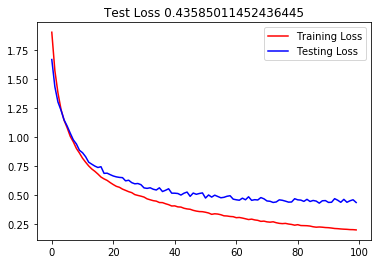

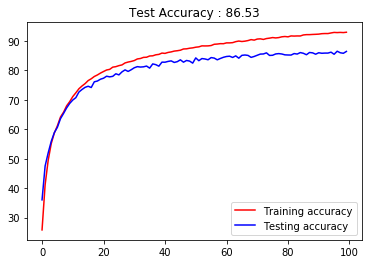

In [18]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', np.max(test_accu))
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss ' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(np.max(test_accu)))
plt.legend()
plt.show()

## Inferences
* It is clear from the abive graph that, there is overfitting in the network.
* I tried different menthods like changing dropouts and actiavtion functions to do address this.
* This did not help as, even though the overfitting decreased the final test accuracy always decreased.
* Adam gave beteer performance than SGD.
* The haphazard motion of both error and accuracy is due to the random shuffling of data in minibatches after each epoch.

# Incorrect Predictions


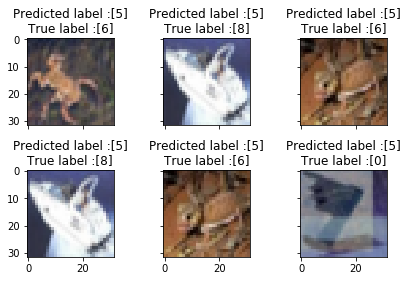

In [19]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
n = 6   # Number of False predictions to output

vis_loader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)


# vis_loader = torch.utils.data.DataLoader(
#     FlowerLoader(x_test, y_test, transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.ToTensor(),
#         normalize,
#     ])), shuffle=False)

for data, target in vis_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    predictedlabel.append(pred.item())
    targetlabel.append(target.item())
    neg = ~pred.eq(target.view_as(pred))
    ind.append(neg.item())
    
    
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

#======= Plotting Incorrect=======
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[maxerrorind[row+col]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
fig.tight_layout()


## Correct Predictions

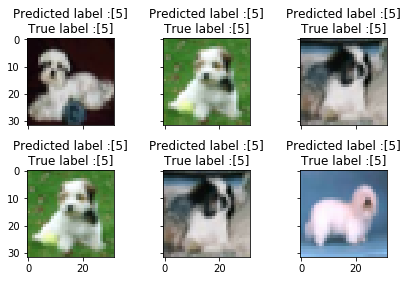

In [20]:
#======= Plotting Correct=======

ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]


nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[maxerrorind[row+col]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
fig.tight_layout()